# **Homework1**

 Implement a genetic algorithm for model structure selection for CIFAR-10 dataset. Compare with random structure selection. Model: 3-layer network. Structure: binary mask for each parameter. Plots: model peformance, mask.
 
<img src="https://drive.google.com/uc?export=view&id=1FEYFTGg-FuedogoZ6hKu9in3J-KOiVXT" width="600" height="800">


Algorithm:

*Initialization*: The algorithm starts by creating a population of randomly generated potential solutions, also called individuals or chromosomes.

*Evaluation*: Each individual's fitness is assessed using a predefined fitness function, which scores how well the solution meets the problem's requirements.

*Selection*: Individuals are selected for reproduction based on their fitness score. The 'fittest' individuals have a higher chance of being selected.

*Crossover (Recombination)*: Pairs of individuals undergo crossover, swapping portions of their code to create offspring. This helps mix and spread valuable traits within the population.

*Mutation*: Random changes are introduced in the offspring, maintaining diversity within the population and preventing premature convergence.

*Looping*: The algorithm repeats from the evaluation step with the new generation until an optimal solution is found or a stopping criterion is reached.

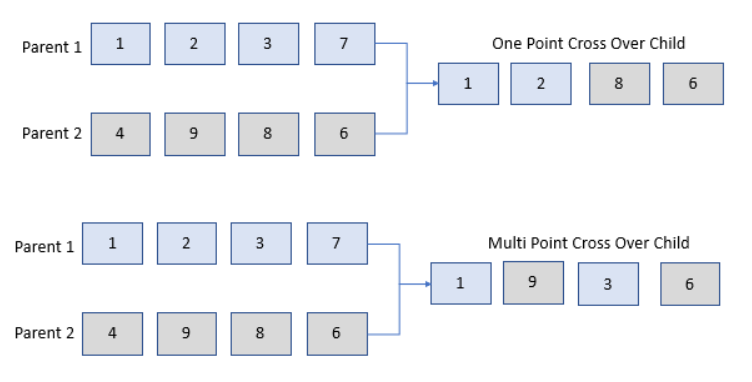

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
import tqdm

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
device

device(type='cuda')

In [10]:
# Data cifar10
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, mask1, mask2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias=False)
        self.fc2 = nn.Linear(hidden_size, output_size, bias=False)
        self.mask1 = mask1.to(device)
        self.mask2 = mask2.to(device)

    def forward(self, x):
        x = torch.relu(self.fc1(x * self.mask1))
        x = self.fc2(x * self.mask2)
        return x

In [12]:
# Genetic Algorithm for MLP Structure Selection
def evaluate_fitness(model, criterion, optimizer, trainloader, testloader, mask1, mask2):
    model.train()
    mask1 = mask1.to(device)
    mask2 = mask2.to(device)
    for epoch in range(5):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            #mask1 = mask1.to(device)
            #mask2 = mask2.to(device)
            inputs = inputs.view(-1, 32 * 32 * 3)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            images = images.view(-1, 32 * 32 * 3)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def initialize_population(population_size, gene_length):
    population = []
    for _ in range(population_size):
        mask1 = torch.randint(2, (gene_length[0],), dtype=torch.float32)
        mask2 = torch.randint(2, (gene_length[1],), dtype=torch.float32)
        population.append([mask1, mask2])
    return population

def crossover(parent1, parent2):
    crossover_point = random.randint(1, len(parent1))
    child1 = [torch.cat((parent1[0][:crossover_point], parent2[0][crossover_point:])),
              torch.cat((parent1[1][:crossover_point], parent2[1][crossover_point:]))]
    child2 = [torch.cat((parent2[0][:crossover_point], parent1[0][crossover_point:])),
              torch.cat((parent2[1][:crossover_point], parent1[1][crossover_point:]))]
    return child1, child2

def mutate(individual):
    mutation_point = random.randint(0, len(individual[0]) - 1)
    individual[0][mutation_point] = 1 - individual[0][mutation_point]
    mutation_point = random.randint(0, len(individual[1]) - 1)
    individual[1][mutation_point] = 1 - individual[1][mutation_point]
    return individual

In [14]:
input_size = 32 * 32 * 3
hidden_size = 100
output_size = 10

population_size = 10
gene_length = [input_size, hidden_size]
generations = 3

population = initialize_population(population_size, gene_length)
best_fitness_score = 0
best_individual = None
all_fitness_scores = []

for generation in tqdm.tqdm(range(generations)):
    fitness_scores = []
    for individual in tqdm.tqdm(population):
        mask1 = individual[0].reshape((input_size))
        mask2 = individual[1].reshape((hidden_size))
        model = MLP(input_size, hidden_size, output_size, mask1, mask2)
        model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        fitness_score = evaluate_fitness(model, criterion, optimizer, trainloader, testloader, mask1, mask2)
        fitness_scores.append(fitness_score)
        if fitness_score > best_fitness_score:
            best_fitness_score = fitness_score
            best_individual = individual

    all_fitness_scores.append(max(fitness_scores))

    print(f"Generation {generation+1}: Best Fitness Score - {max(fitness_scores)}")

    new_population = []
    for _ in range(population_size // 2):
        parent1, parent2 = random.choices(population, k=2, weights=fitness_scores)
        child1, child2 = crossover(parent1, parent2)
        child1 = mutate(child1)
        child2 = mutate(child2)
        new_population.extend([child1, child2])

    population = new_population

 33%|███▎      | 1/3 [02:26<04:52, 146.06s/it]

Generation 1: Best Fitness Score - 0.4507



 67%|██████▋   | 2/3 [04:51<02:25, 145.84s/it]

Generation 2: Best Fitness Score - 0.4498



100%|██████████| 3/3 [07:17<00:00, 145.99s/it]

Generation 3: Best Fitness Score - 0.4449


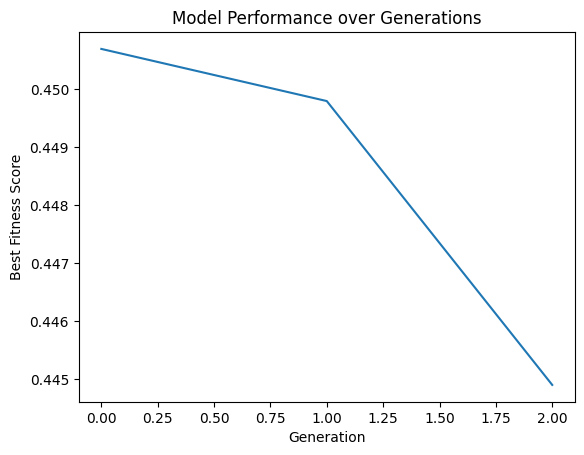

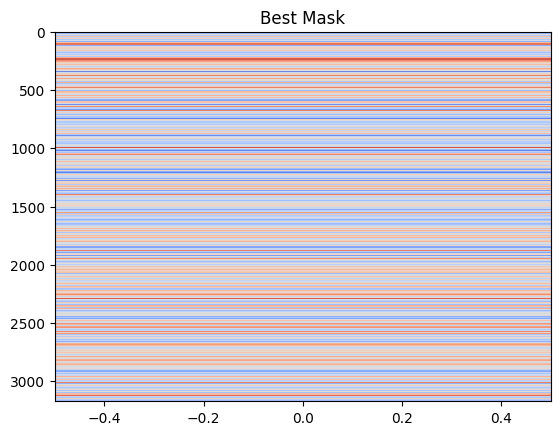

In [15]:
plt.figure()
plt.plot(all_fitness_scores)
plt.xlabel('Generation')
plt.ylabel('Best Fitness Score')
plt.title('Model Performance over Generations')
plt.show()

best_mask_image = torch.cat((best_individual[0].reshape((input_size, 1)), best_individual[1].reshape((hidden_size, 1))), dim=0).cpu()
plt.figure()
plt.imshow(best_mask_image.numpy(), cmap='coolwarm', aspect='auto')
plt.title('Best Mask')
plt.show()

Summary: To make a better prediction, that is, to get a larger metric, you need to put the number of populations more, at least 100, and the number of generations, but it will take 5 hours to learn, so I chose fewer generations, but in principle the quality is already good, even if compared with a model that selects hyperparameters below.

## Bonus: Implementation hyperparameter selection

In [16]:
from keras import datasets
from random import choice
from random import uniform
from numpy.random import randint
from tensorflow.keras import utils
from keras import layers
from keras import models
from keras.callbacks import EarlyStopping

2024-02-29 01:51:30.288155: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-29 01:51:31.148888: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [17]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

train_images =x_train.astype('float32')/255
test_images=x_test.astype('float32')/255

In [18]:
train_labels=utils.to_categorical(y_train)
test_labels=utils.to_categorical(y_test)

In [19]:
val_images=train_images[:10000]
partial_images=train_images[10000:]

val_labels=train_labels[:10000]
partial_labels=train_labels[10000:]

In [20]:
def MLP_model( f1, f2, a1, a2, d1, d2, op, ep):
  model = models.Sequential()
  model.add(layers.Flatten())
  model.add(layers.Dropout(rate = d1))
  model.add(layers.Dense(units = f1, activation = a1))
  model.add(layers.Dropout(rate = d2))
  model.add(layers.Dense(units = f2, activation = a2))
  model.add(layers.Dense(10, activation= "softmax"))

  model.compile(loss = "categorical_crossentropy", optimizer = op, metrics = ["accuracy"])
  es = EarlyStopping(monitor="val_accuracy", patience = 7)
  model.fit(partial_images, partial_labels, validation_data=(val_images,val_labels), epochs=ep, batch_size = 100, callbacks = [es], verbose=0)

  return model

In [21]:
def initialization():
  parameters = {}
  f1 = choice([128, 256, 512])
  parameters["f1"] = f1
  f2 = choice([128, 256, 512])
  parameters["f2"] = f2
  a1 = choice(["relu", "selu", "elu"])
  parameters["a1"] = a1
  a2 = choice(["relu", "selu", "elu"])
  parameters["a2"] = a2
  d1 = round(uniform(0.1, 0.5), 1)
  parameters["d1"] = d1
  d2 = round(uniform(0.1, 0.5), 1)
  parameters["d2"] = d2
  op = choice(["adamax", "adadelta", "adam", "adagrad"])
  parameters["op"] = op
  ep = randint(50, 100)
  parameters["ep"] = ep
  return parameters

In [22]:
def generate_population(n):
  population = []
  for i in range(n):
    chromosome = initialization()
    population.append(chromosome)
  return population

In [23]:
def fitness_evaluation(model):
  metrics = model.evaluate(test_images, test_labels)
  return metrics[1]

In [24]:
def selection(population_fitness):
  total = sum(population_fitness)
  percentage = [round((x/total) * 100) for x in population_fitness]
  selection_wheel = []
  for pop_index,num in enumerate(percentage):
    selection_wheel.extend([pop_index]*num)
  parent1_ind = choice(selection_wheel)
  parent2_ind = choice(selection_wheel)
  return [parent1_ind, parent2_ind]

In [25]:
def crossover(parent1, parent2):
  child1 = {}
  child2 = {}

  child1["f1"] = choice([parent1["f1"], parent2["f1"]])
  child1["f2"] = choice([parent1["f2"], parent2["f2"]])

  child2["f1"] = choice([parent1["f1"], parent2["f1"]])
  child2["f2"] = choice([parent1["f2"], parent2["f2"]])

  child1["a1"] = parent1["a2"]
  child2["a1"] = parent2["a2"]

  child1["a2"] = parent2["a1"]
  child2["a2"] = parent1["a1"]

  child1["d1"] = parent1["d1"]
  child2["d1"] = parent2["d1"]

  child1["d2"] = parent2["d2"]
  child2["d2"] = parent1["d2"]

  child1["op"] = parent2["op"]
  child2["op"] = parent1["op"]

  child1["ep"] = parent1["ep"]
  child2["ep"] = parent2["ep"]
  return [child1, child2]

In [26]:
def mutation(chromosome):
  flag = randint(0,40)
  if flag <= 20:
    chromosome["ep"] += randint(0, 10)
  return chromosome

In [27]:
generations = 3
threshold = 90
num_pop = 10

population = generate_population(num_pop)

for generation in range(generations):

  population_fitness = []
  for chromosome in population:
    f1 = chromosome["f1"]
    f2 = chromosome["f2"]
    a1 = chromosome["a1"]
    a2 = chromosome["a2"]
    d1 = chromosome["d1"]
    d2 = chromosome["d2"]
    op = chromosome["op"]
    ep = chromosome["ep"]

    try:
      model = MLP_model(f1, f2, a1, a2, d1, d2, op, ep)
      acc = fitness_evaluation(model)
      print("Parameters: ", chromosome)
      print("Accuracy: ", round(acc,3))
    except:
      acc=0
      print("Parameters: ", chromosome)
      print("Invalid parameters - Build fail")

    population_fitness.append(acc)

  parents_ind = selection(population_fitness)
  parent1 = population[parents_ind[0]]
  parent2 = population[parents_ind[1]]

  children = crossover(parent1, parent2)
  child1 = mutation(children[0])
  child2 = mutation(children[1])

  population.append(child1)
  population.append(child2)

  print("Generation ", generation+1," Outcome: ")
  if max(population_fitness) >= threshold:
    print("Obtained desired accuracy: ", max(population_fitness))
    break
  else:
    print("Maximum accuracy in generation {} : {}".format(generation+1, max(population_fitness)))

  first_min = min(population_fitness)
  first_min_ind = population_fitness.index(first_min)
  population.remove(population[first_min_ind])
  second_min = min(population_fitness)
  second_min_ind = population_fitness.index(second_min)
  population.remove(population[second_min_ind])

2024-02-29 01:51:33.189338: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-29 01:51:33.230567: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


313/313 [==============================] - 0s 749us/step - loss: 1.3376 - accuracy: 0.5225
Parameters:  {'f1': 256, 'f2': 128, 'a1': 'elu', 'a2': 'relu', 'd1': 0.4, 'd2': 0.2, 'op': 'adamax', 'ep': 73}
Accuracy:  0.522
313/313 [==============================] - 0s 803us/step - loss: 1.8972 - accuracy: 0.3243
Parameters:  {'f1': 128, 'f2': 512, 'a1': 'elu', 'a2': 'relu', 'd1': 0.4, 'd2': 0.5, 'op': 'adadelta', 'ep': 98}
Accuracy:  0.324
313/313 [==============================] - 0s 920us/step - loss: 1.7330 - accuracy: 0.3949
Parameters:  {'f1': 512, 'f2': 128, 'a1': 'elu', 'a2': 'elu', 'd1': 0.2, 'd2': 0.2, 'op': 'adadelta', 'ep': 88}
Accuracy:  0.395
313/313 [==============================] - 0s 660us/step - loss: 1.3660 - accuracy: 0.5071
Parameters:  {'f1': 128, 'f2': 128, 'a1': 'elu', 'a2': 'relu', 'd1': 0.2, 'd2': 0.2, 'op': 'adamax', 'ep': 56}
Accuracy:  0.507
313/313 [==============================] - 0s 852us/step - loss: 1.7627 - accuracy: 0.3735
Parameters:  {'f1': 128, 'f2':

**Best params:** 

*Parameters*:  neurons 1 layer - 128, neurons 2 layer - 128, activation 1 - 'elu', activation 2 - 'relu', dropout probs 1 - 0.2, dropout probs 2 - 0.2, optimizer - 'adamax', epochs - 56

**Accuracy - 0.533**